In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from PIL import Image
import numpy as np
import glob
import cv2

In [2]:
# data_paths = glob.glob('/hdd/dataset/nuclei_dataset/stage1_train/*/')
data_paths = glob.glob('./stage1_train/*/')

In [3]:
IMG_DIM = 448

In [4]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import keras
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, UpSampling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Build U-Net model
# From kernel https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


/home/peter/virtual_envs/tf_keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras.layers import Lambda, Add, Activation

def build_stage(inputs, last=None, id_='st1'):
    def conv(f, k=3, act='relu'):
        return Conv2D(f, (k, k), activation=act, kernel_initializer='he_normal', padding='same')
    def _incept_conv(inputs, f, dropout=0.1, chs=[0.15, 0.5, 0.25, 0.1]):
        fs = [] # determine channel number
        for k in chs:
            t = max(int(k*f), 1) # at least 1 channel
            fs.append(t)
        
        fs[1] += f-np.sum(fs) # reminding channels allocate to 3x3 conv
        
        c1x1 = conv(fs[0], 1, act='linear') (inputs)
        c3x3 = conv(max(1, fs[1]//2), 1, act='relu') (inputs)
        c5x5 = conv(max(1, fs[2]//2), 1, act='relu') (inputs)
        cpool= MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same') (inputs)
        
        c3x3 = conv(fs[1], 3, act='linear') (c3x3)
        c5x5 = conv(fs[2], 5, act='linear') (c5x5)
        cpool= conv(fs[3], 1, act='linear') (cpool)
        
        output = concatenate([c1x1, c3x3, c5x5, cpool], axis=-1)
        return output
    
    def _res_conv(inputs, f, k=3, dropout=0.1): # very simple residual module
        channels = int(inputs.shape[-1])
        
        cs = _incept_conv(inputs, f)
        
        if f!=channels:
            t1 = conv(f, 1, 'linear') (inputs) # identity mapping
        else:
            t1 = inputs
        
        out = Add()([t1, cs]) # t1 + c2
        out = Activation('relu') (out)
        return out
    def pool():
        return MaxPooling2D((2, 2))
    def up():
        return UpSampling2D()
    
    if last is None:
        c1 = Lambda(lambda x: x / 255) (inputs) # 1st stage input, an image
    else:
        c1 = Add()([inputs, last]) # dimensions of inputs, last are same
    
    c1 = _res_conv(c1, 16, 3, dropout=0.1)
    o1 = c1
    p1 = pool() (c1)
    
    c2 = _res_conv(p1, 32, 3, dropout=0.1)
    p2 = pool() (c2)

    c3 = _res_conv(p2, 64, 3, dropout=0.2)
    p3 = pool() (c3)
    
    c4 = _res_conv(p3, 128, 3, dropout=0.2)
    p4 = pool() (c4)
    
    c5 = _res_conv(p4, 256, 3, dropout=0.25)
    p5 = pool() (c5)
    
    c6 = _res_conv(p5, 512, 3, dropout=0.3)
    
    u7 = up() (c6)
    c7 = concatenate([u7, c5])
    c7 = _res_conv(c7, 256, 3, dropout=0.25)
    
    u8 = up() (c7)
    c8 = concatenate([u8, c4])
    c8 = _res_conv(c8, 128, 3, dropout=0.2)
    
    u9 = up() (c8)
    c9 = concatenate([u9, c3])
    c9 = _res_conv(c9, 64, 3, dropout=0.2)
    
    u10 = up() (c9)
    c10 = concatenate([u10, c2])
    c10 = _res_conv(c10, 32, 3, dropout=0.1)
    
    u11 = up() (c10)
    c11 = concatenate([u11, c1])
    c11 = _res_conv(c11, 16, 3, dropout=0.1)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid', name=id_+'_out') (c11)
    return outputs, o1

inputs = Input((IMG_DIM, IMG_DIM, 3))
out1, t1 = build_stage(inputs, None, 'st1')
out2, t2 = build_stage(out1, t1, 'st2')
out3, t3 = build_stage(out2, t2, 'st3')

model = Model(inputs=[inputs], outputs=[out1, out2, out3])


In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def IOU_approximation_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    insc = K.sum(y_true_f * y_pred_f)
    return -(insc + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) - insc + 1.)

model.summary()
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[mean_iou]
             )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 448, 448, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 448, 448, 4)  16          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 448, 448, 2)  8           lambda_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [7]:
data = []
label = []
for filepath in data_paths:
    file_id = filepath.split('/')[-2]
    img_path = glob.glob(filepath+'images/*.png')
    mask_paths = glob.glob(filepath+'masks/*.png')
    
    # read input img:
    img = cv2.imread(img_path[0])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    assert(img.ndim==1 or img.ndim>=3)
    # img = img.astype(np.float32) / 255. # normalize
    if img.ndim==1:
        img = np.repeat(img, 3, axis=-1)
    img = img[...,:3]
    
    # merge output masks:
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for mask_path in mask_paths:
        msk = cv2.imread(mask_path, 0)
        mask = np.maximum(mask, msk) # merge
    data.append(img)
    label.append(mask)
print(len(data))
print(len(data))

670
670


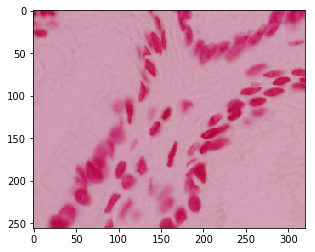

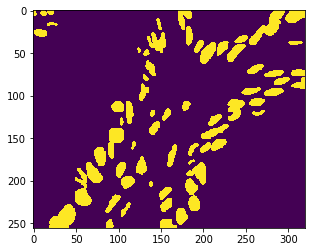

In [8]:
plt.imshow(data[320])
plt.show()
plt.imshow(label[320])
plt.show()

In [9]:
from sklearn.utils import shuffle
def data_generator(data, label, batch_size=4, val=False):
    def do_CLAHE(img, bin_=8):
        Lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        Lab_planes = cv2.split(Lab)
        clahe = cv2.createCLAHE(clipLimit=2., tileGridSize=(bin_,bin_))
        Lab_planes[0] = clahe.apply(Lab_planes[0])
        Lab = cv2.merge(Lab_planes)
        return cv2.cvtColor(Lab, cv2.COLOR_LAB2BGR) # (?, ?, 3)
    index = 0
    dat_que = np.empty((batch_size, IMG_DIM, IMG_DIM, 3), dtype=np.uint8)
    lab_que = np.empty((batch_size, IMG_DIM, IMG_DIM, 1), dtype=np.bool)
    while True:
        img = data[index%len(data)] # [0,255]
        lab = label[index%len(data)] # [0, 1] float
        
        #### Begining of data augmentation ####
        if not val:
            if np.random.rand() < .5: # flip vertical
                img = np.flip(img, 0)
                lab = np.flip(lab, 0)
            if np.random.rand() < .5: # flip horizontal
                img = np.flip(img, 1)
                lab = np.flip(lab, 1)
            
            # rotation
            if np.random.rand() < 0.3:
                y, x, _ = img.shape
                h, w = y, x
                img = cv2.copyMakeBorder(img, y//2, y//2, x//2, x//2, cv2.BORDER_REFLECT)
                lab = cv2.copyMakeBorder(lab, y//2, y//2, x//2, x//2, cv2.BORDER_REFLECT)
                y, x, _ = img.shape
                rotT = np.random.uniform(-30,30)
                M = cv2.getRotationMatrix2D((x/2, y/2), rotT, 1)
                img = cv2.warpAffine(img, M, (x, y))
                lab = cv2.warpAffine(lab, M, (x, y))
                img = img[h//2:h//2+h,w//2:w//2+w,:]
                lab = lab[h//2:h//2+h,w//2:w//2+w]
            
            img = img.astype(np.float32) / 255. # normalize
            
            # random amplify each channel
            a = .05 # amptitude
            t  = [np.random.uniform(-a,a)]
            t += [np.random.uniform(-a,a)]
            t += [np.random.uniform(-a,a)]
            t = np.array(t)

            img = img * (1. + t) # channel wise amplify
            up = np.random.uniform(0.95, 1.05) # change gamma
            img = img**up * 255. # apply gamma and convert back to range [0,255]
            img = img.astype(np.uint8) # convert back to uint8
        
        # img = do_CLAHE(img, bin_ = 8) # (?, ?, 3) -> (?, ?, 3)
        assert img.dtype == np.uint8 ## check type
        assert lab.dtype == np.uint8
        
        x_off = IMG_DIM - img.shape[1]
        y_off = IMG_DIM - img.shape[0]
        
        INPT = cv2.INTER_CUBIC if img.shape[0]<IMG_DIM or img.shape[1]<IMG_DIM else cv2.INTER_AREA
        img = cv2.resize(img, (IMG_DIM, IMG_DIM), interpolation=INPT)
        lab = cv2.resize(lab, (IMG_DIM, IMG_DIM), interpolation=INPT)
        lab[lab<127] = 0
        lab[lab>0] = 1
        #### End of data augmentation ####
        
        dat_que[index%batch_size,:,:,:] = img
        lab_que[index%batch_size,:,:,0] = lab
        index = index + 1
        if index%batch_size==0:
            index = 0 if index%len(data)==0 else index
            yield (dat_que, [lab_que, lab_que, lab_que])
        if index%len(data)==0:
            data, label = shuffle(data, label)
        

In [10]:
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger
TENSORBOARD_PATH = './tfboard'

X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.1, shuffle=True)

In [11]:
from keras.callbacks import Callback

class Peek(Callback):
    def __init__(self, path, n=5):
        self.img_path = path+'/input'
        self.gt_path = path+'/gt'
        self.pred_path = path+'/pred'
        os.makedirs(self.img_path, exist_ok=True)
        os.makedirs(self.gt_path, exist_ok=True)
        os.makedirs(self.pred_path, exist_ok=True)
        sample = np.random.choice(len(X_val), n, replace=False)
        self.data = np.zeros((n, IMG_DIM, IMG_DIM, 3), dtype=np.uint8)
        for ii, i in enumerate(sample):
            img = X_val[i]
            lab = y_val[i]
            INPT = cv2.INTER_CUBIC if img.shape[0]<IMG_DIM or img.shape[1]<IMG_DIM else cv2.INTER_AREA
            img = cv2.resize(img, (IMG_DIM, IMG_DIM), interpolation=INPT)
            lab = cv2.resize(lab, (IMG_DIM, IMG_DIM), interpolation=INPT)
            cv2.imwrite(self.img_path+'/%02d.jpg'%ii, img)
            cv2.imwrite(self.gt_path+'/%02d.jpg'%ii, lab)
            self.data[ii, :, :, :] = img
    def on_epoch_end(self, epoch, logs):
        preds = self.model.predict(self.data, batch_size=min(4, len(self.data)))[-1] * 255.
        preds = preds.astype(np.uint8)
        preds = np.squeeze(preds)
        os.makedirs(self.pred_path+'/%d'%epoch, exist_ok=True)
        for i, img in enumerate(preds):
            cv2.imwrite(self.pred_path+'/%d/%02d.jpg'%(epoch, i), img)

In [ ]:
BATCH_SIZE=4
EPOCHS=50

# os.makedirs('/hdd/dataset/nuclei_dataset/weights', exist_ok=True)
os.makedirs('./weights', exist_ok=True)

model.fit_generator(generator=data_generator(X_train, y_train, batch_size=BATCH_SIZE, val=False), steps_per_epoch=int( len(X_train)//BATCH_SIZE ), epochs=EPOCHS, validation_data=data_generator(X_val, y_val, batch_size=BATCH_SIZE, val=True), validation_steps=int( len(X_val)//BATCH_SIZE ), 
                    callbacks=[
                        TensorBoard(log_dir=TENSORBOARD_PATH),
                        #EarlyStopping(patience=15),
                        #ModelCheckpoint('/hdd/dataset/nuclei_dataset/weights/weights.{epoch:03d}-{val_loss:.2f}-{val_st3_out_mean_iou:.2f}.hdf5'),
                        ModelCheckpoint('./weights/weights.{epoch:03d}-{val_loss:.2f}-{val_st3_out_mean_iou:.2f}.hdf5'),
                        #ModelCheckpoint('/hdd/dataset/nuclei_dataset/weights/weights.{epoch:03d}-{val_loss:.2f}-{val_mean_iou:.2f}.hdf5'),
                        #ModelCheckpoint('./weights/weights.{epoch:03d}-{val_loss:.2f}-{val_mean_iou:.2f}.hdf5'),
                        CSVLogger('train.log.csv'),
                        #Peek('/hdd/dataset/nuclei_dataset/vis', 10)
                        Peek('./vis', 10)
                    ])

Epoch 1/50
150/150 [==============================] - 301s 2s/step - loss: 0.8546 - st1_out_loss: 0.2883 - st2_out_loss: 0.2921 - st3_out_loss: 0.2741 - st1_out_mean_iou: 0.4391 - st2_out_mean_iou: 0.4483 - st3_out_mean_iou: 0.4672 - val_loss: 0.7675 - val_st1_out_loss: 0.1858 - val_st2_out_loss: 0.3237 - val_st3_out_loss: 0.2580 - val_st1_out_mean_iou: 0.4592 - val_st2_out_mean_iou: 0.5094 - val_st3_out_mean_iou: 0.5438
Epoch 2/50
 40/150 [=======>......................] - ETA: 2:55 - loss: 0.4346 - st1_out_loss: 0.1721 - st2_out_loss: 0.1421 - st3_out_loss: 0.1204 - st1_out_mean_iou: 0.4578 - st2_out_mean_iou: 0.5254 - st3_out_mean_iou: 0.5623

65


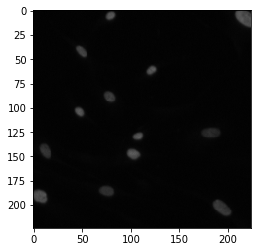

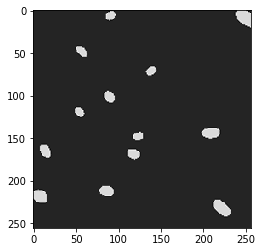

In [117]:
from skimage.transform import resize
import skimage.morphology.label as lb

test_path = glob.glob('./stage1_test/*/')
print(len(test_path))
test_imgs = np.zeros((len(test_path), IMG_DIM, IMG_DIM, 3), np.uint8)
test_resolutions = []
test_id = []

for i, filepath in enumerate(test_path):
    file_id = filepath.split('/')[-2]
    test_id.append(file_id)
    img_path = glob.glob(filepath+'images/*.png')
    
    # read input img:
    img = cv2.imread(img_path[0])
    assert(img.ndim==1 or img.ndim>=3)
    if img.ndim==1:
        img = np.repeat(img, 3, axis=-1)
    img = img[...,:3]
    test_resolutions.append((img.shape[1], img.shape[0]))
    INPT = cv2.INTER_CUBIC if img.shape[0]<IMG_DIM or img.shape[1]<IMG_DIM else cv2.INTER_AREA
    img = cv2.resize(img, (IMG_DIM, IMG_DIM), interpolation=INPT)
    test_imgs[i, :, :, :] = img

preds = model.predict(test_imgs, batch_size=BATCH_SIZE)[-1]
preds = np.squeeze(preds)

new_masks = []
for i, mask in enumerate(preds): # upsample to original size
    mask = cv2.resize(mask, test_resolutions[i], interpolation=cv2.INTER_CUBIC)
    new_masks.append(mask)

test_show_mask = np.squeeze(new_masks[1])*255

plt.imshow(test_imgs[1])
plt.show()
plt.imshow(test_show_mask, cmap='gray')
plt.show()


In [118]:
def rle_encoding(img):
    flat_img = img.flatten()
    flat_img = np.where(flat_img > 0.5, 1, 0).astype(np.uint8)
    flat_img = np.insert(flat_img, [0, len(flat_img)], [0, 0])

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 1
    ends_ix = np.where(ends)[0] + 1
    lengths = ends_ix - starts_ix

    encoding = ''
    for idx in range(len(starts_ix)):
        encoding += '%d %d ' % (starts_ix[idx], lengths[idx])
    return encoding

def rle_decode(rle_str, mask_shape, mask_dtype):
    s = rle_str.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(mask_shape)

def prob_to_rles(x, cutoff=0.5):
    lab_img = lb(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_id):
    rle = list(prob_to_rles(new_masks[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)